In [50]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')


### **Membaca data CSV**

In [51]:
df_customer = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Internship Rakamin - Kalbe/Customer.csv', delimiter=';')
df_product = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Internship Rakamin - Kalbe/Product.csv',delimiter=';')
df_store = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Internship Rakamin - Kalbe/Store.csv', delimiter=';')
df_transaction = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Internship Rakamin - Kalbe/Transaction.csv',delimiter=';')

In [52]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

### **Data Cleansing**

In [53]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [54]:
df_customer.duplicated().sum()

0

In [55]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [56]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4
415,416,27,1,NaN,"3,43"
442,443,33,1,NaN,"9,28"


In [57]:
df_customer = df_customer.dropna(how='any')

In [58]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [59]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [60]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [61]:
# data cleansing df customer
df_customer['Income'] = df_customer['Income'].replace('[,]', '.', regex=True).astype('float')

In [62]:
# data cleansing df store
df_store['Latitude'] = df_store['Latitude'].replace('[,]', '.', regex=True).astype('float')
df_store['Longitude'] = df_store['Longitude'].replace('[,]', '.', regex=True).astype('float')

In [63]:
# data cleansing df transaction
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [64]:
df_transaction['TransactionID'].value_counts()

TR71313    3
TR42197    2
TR90402    2
TR74019    2
TR49649    2
          ..
TR29792    1
TR23081    1
TR1691     1
TR98388    1
TR85684    1
Name: TransactionID, Length: 4908, dtype: int64

In [65]:
df_transaction[df_transaction['TransactionID'] == 'TR71313']

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
1982,TR71313,117,2022-05-21,P1,8800,10,88000,8
3336,TR71313,401,2022-08-30,P3,7500,6,45000,11
3722,TR71313,370,2022-09-26,P3,7500,2,15000,3


### **Gabungkan Data**

In [66]:
df_merge = pd.merge(df_transaction, df_customer, on = ['CustomerID'])
df_merge = pd.merge(df_merge, df_product.drop(columns=['Price']), on = ['ProductID'])
df_merge = pd.merge(df_merge, df_store, on = ['StoreID'])

In [67]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [68]:
df_regresi = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
}).reset_index()

In [69]:
df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


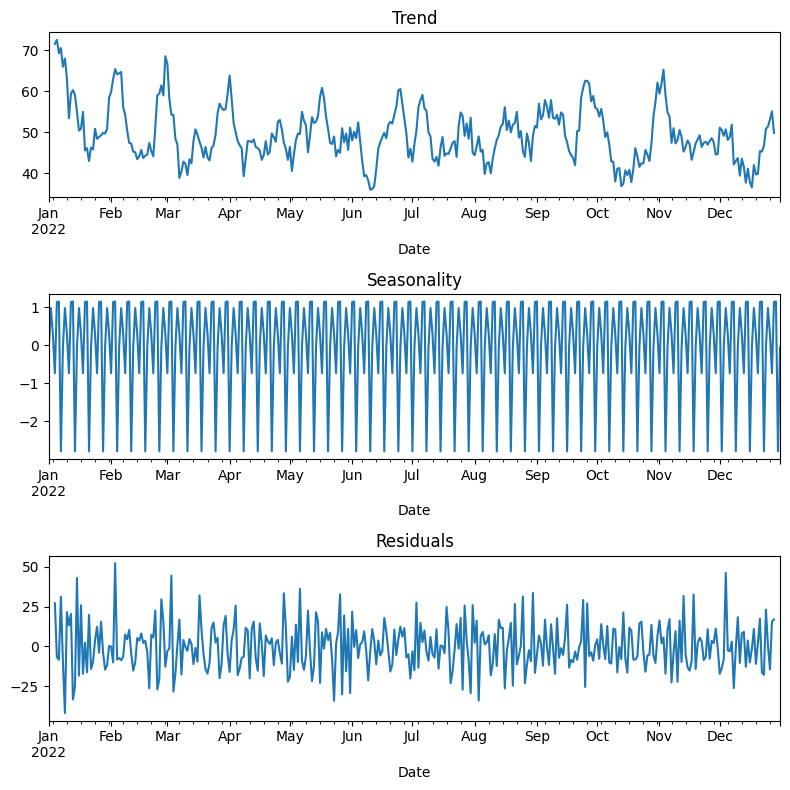

In [70]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))
plt.figure(figsize=(8,8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

### **Uji Stasioner**

In [71]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_regresi['Qty'])
print('ADF Statistic: %f' % result[0])
print('P-Value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -19.091514
P-Value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571


In [72]:
cut_off = round(df_regresi.shape[0] * 0.8)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)
df_train.shape, df_test.shape

((292, 2), (73, 2))

In [73]:
df_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,24
289,2022-10-17,53
290,2022-10-18,47


In [74]:
df_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,40


<Axes: xlabel='Date', ylabel='Qty'>

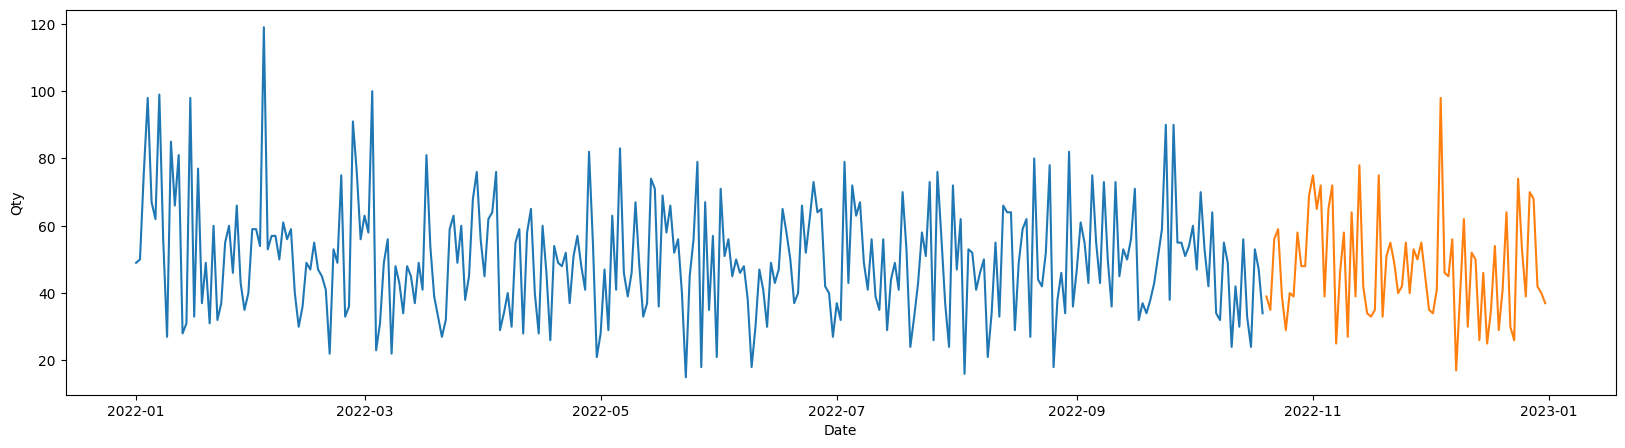

In [75]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

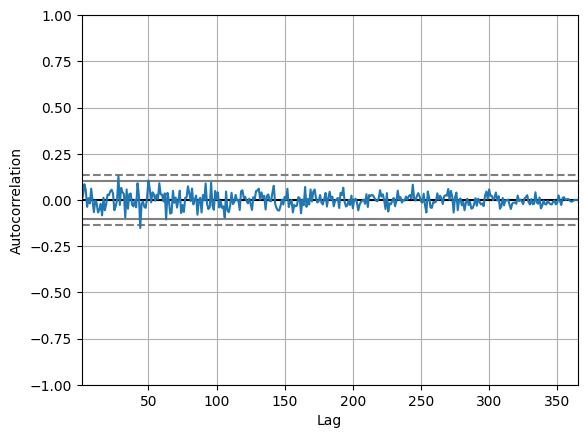

In [76]:
autocorrelation_plot(df_regresi['Qty'])

In [77]:
def rmse(y_actual, y_pred):
  print(f'RMSE {mean_squared_error(y_actual, y_pred)**0.5}')

def eval(y_actual, y_pred):
  rmse(y_actual, y_pred)
  print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

RMSE 15.856695195531067
MAE value 12.625558626204052


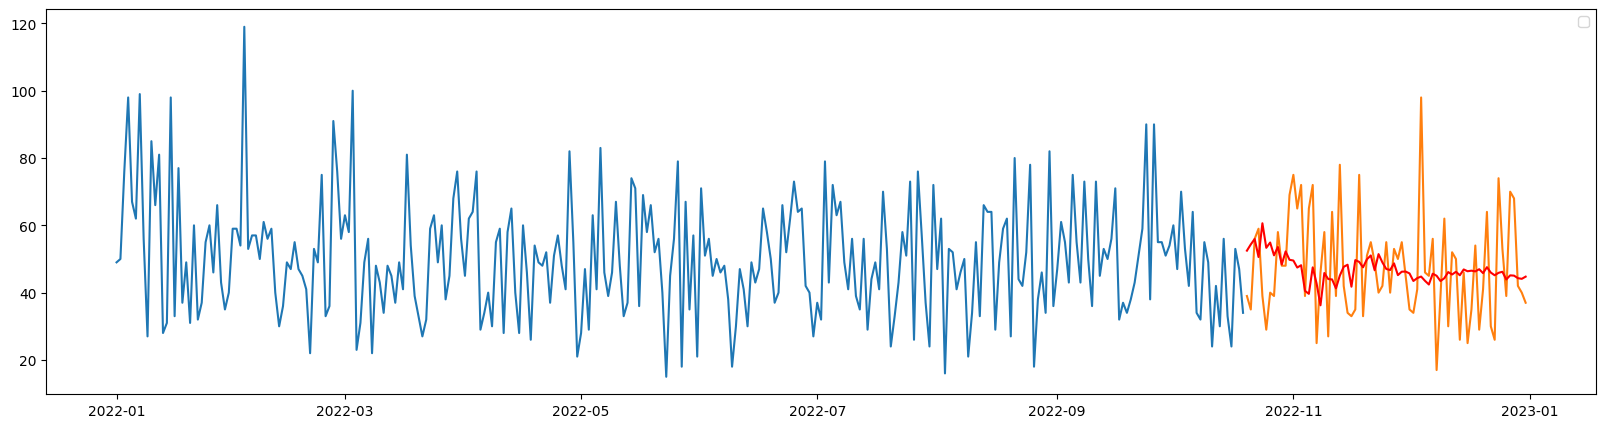

In [78]:
# ARIMA
df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']
ARIMAmodel = ARIMA(y, order = (40, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end= y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']
eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'])
plt.plot(y_pred_out, color='r')
plt.legend()

### **Clustering**

In [79]:
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554


In [80]:
df_merge.corr()

,CustomerID,Price,Qty,TotalAmount,StoreID,Age,Gender,Income,Latitude,Longitude
CustomerID,1.000000,-0.014821,-0.012024,-0.025266,0.005470,-0.021120,-0.015863,0.005440,0.005166,-0.004492
Price,-0.014821,1.000000,-0.354614,0.440046,-0.031782,0.013781,0.012132,0.000636,-0.027438,0.017238
Qty,-0.012024,-0.354614,1.000000,0.620804,0.012169,-0.026745,-0.011920,-0.027724,-0.007179,0.006805
TotalAmount,-0.025266,0.440046,0.620804,1.000000,-0.011283,-0.016458,-0.009479,-0.024816,-0.030704,0.026535
StoreID,0.005470,-0.031782,0.012169,-0.011283,1.000000,-0.004783,0.000449,0.000739,0.471039,-0.095710
Age,-0.021120,0.013781,-0.026745,-0.016458,-0.004783,1.000000,-0.026879,0.485532,0.009474,0.015670
Gender,-0.015863,0.012132,-0.011920,-0.009479,0.000449,-0.026879,1.000000,-0.067612,-0.006624,-0.001018
Income,0.005440,0.000636,-0.027724,-0.024816,0.000739,0.485532,-0.067612,1.000000,0.016401,0.003471
Latitude,0.005166,-0.027438,-0.007179,-0.030704,0.471039,0.009474,-0.006624,0.016401,1.000000,-0.396128
Longitude,-0.004492,0.017238,0.006805,0.026535,-0.095710,0.015670,-0.001018,0.003471,-0.396128,1.000000


In [84]:
df_cluster = df_merge.groupby(['CustomerID']).agg({
    'TransactionID' : 'count',
    'Qty' : 'sum',
    'Age' : 'first'
}).reset_index().rename(columns ={
    'TransactionID' : 'Count_Transaction',
    'Qty' : 'Total_Qty'
})

In [85]:
df_cluster

,CustomerID,Count_Transaction,Total_Qty,Age
0,1,17,60,55
1,2,13,57,60
2,3,15,56,32
3,4,10,46,31
4,5,7,27,58
...,...,...,...,...
439,442,13,37,42
440,444,18,62,53
441,445,18,68,51
442,446,11,42,57


In [89]:
data_cluster = df_cluster.drop(columns=['CustomerID'])
data_cluster_normalize = preprocessing.normalize(data_cluster)

In [90]:
data_cluster_normalize

array([[0.20444864, 0.72158345, 0.66145149],
       [0.15518033, 0.68040606, 0.71621691],
       [0.22651995, 0.84567449, 0.48324256],
       ...,
       [0.20717044, 0.78264389, 0.58698292],
       [0.15351993, 0.58616699, 0.79551234],
       [0.18668837, 0.60314704, 0.77547476]])

In [91]:
K = range(2,8)
fits = []
score=[]

for k in K:
  model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(data_cluster_normalize)

  fits.append(model)

  score.append(silhouette_score(data_cluster_normalize, model.labels_, metric='euclidean'))

<Axes: >

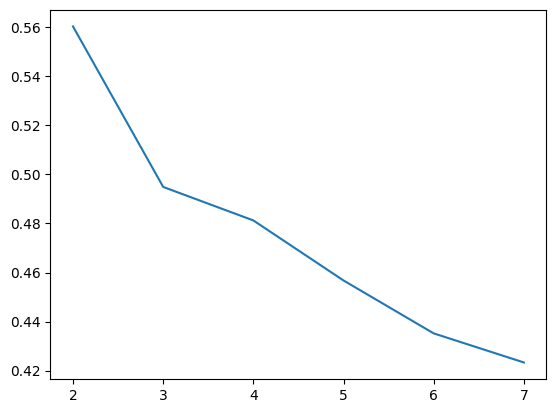

In [92]:
sns.lineplot(x= K,y= score)

In [94]:
fits[2]

KMeans(n_clusters=4, n_init='auto', random_state=0)

In [96]:
df_cluster['Cluster_Label'] = fits[2].labels_

In [97]:
df_cluster

,CustomerID,Count_Transaction,Total_Qty,Age,Cluster_Label
0,1,17,60,55,0
1,2,13,57,60,1
2,3,15,56,32,2
3,4,10,46,31,0
4,5,7,27,58,3
...,...,...,...,...,...
439,442,13,37,42,1
440,444,18,62,53,0
441,445,18,68,51,0
442,446,11,42,57,1


In [98]:
df_cluster.groupby(['Cluster_Label']).agg({
    'CustomerID' : 'count',
    'Count_Transaction' : 'mean',
    'Total_Qty' : 'mean',
    'Age' : 'mean'
})

,CustomerID,Count_Transaction,Total_Qty,Age
Cluster_Label,,,,
0,129,12.108527,45.720930,34.573643
1,140,11.250000,39.564286,44.800000
2,70,13.714286,52.957143,24.600000
3,105,8.371429,28.390476,49.857143
